## Topic 1: Train Your Very First Pytorch Model!¶
We will tackle this problem in 3 parts:

1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [1]:
# Install torch, depends on cuda version
# https://pytorch.org/get-started/locally/

In [2]:
import torch #Import PyTorch
import torch.nn as nn #Specific funtions related to NeuralNetwork
import torch.optim as optim #Optimizer
from torch.utils.data import Dataset, DataLoader
import torchvision #Useful for image classification
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
import os
from tqdm.notebook import tqdm
import gc
import random

torch.manual_seed(123)
random.seed(123)
np.random.seed(123)

In [3]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.8.0+cu128
Torchvision version 0.23.0+cu128
Numpy version 1.26.4
Pandas version 2.2.3


## Step1: Loading Datasets

In [4]:
#We will use MNIST, which is hand-written digit image dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert 1 → 3 channels
    transforms.Resize(224),                        # ResNet expects at least 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3-channel normalization
])

# Download and load MNIST
# Training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# Testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Split testset 50-50 into validation and test
total_test_size = len(testset)
val_size = test_size = total_test_size // 2  # 50-50 split
valset, new_testset = torch.utils.data.random_split(testset, [val_size, test_size])
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(new_testset, batch_size=64, shuffle=False)
print(f"Train size: {len(trainset)}, Validation size: {len(valset)}, Test size: {len(new_testset)}")

Train size: 60000, Validation size: 5000, Test size: 5000


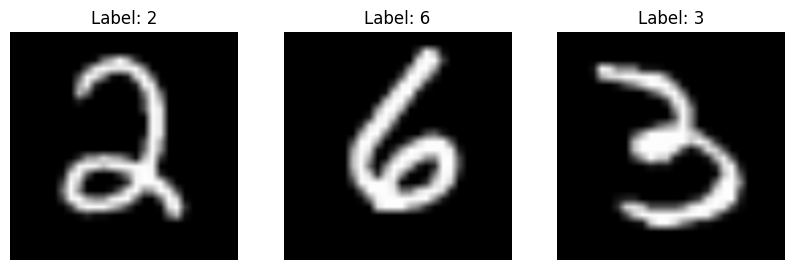

In [25]:
# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # images: [batch_size, 3, 32, 32]

# Undo normalization for display
images_show = images * 0.5 + 0.5  # assuming Normalize((0.5,), (0.5,))

# Plot 3 images in a row
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    npimg = np.transpose(images_show[i].numpy(), (1, 2, 0))  # [C,H,W] -> [H,W,C]
    axes[i].imshow(npimg)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

## Step2: Pytorch Model

First we will build a small model, consisting of 2 Linear layers with a ReLu activation funtion

In [6]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes = 2):
        super(SimpleModel, self).__init__()
        self.Linear1 = nn.Linear(100,200)
        self.Activation1 = nn.ReLU()
        self.Linear2 = nn.Linear(200,num_classes)
        self.Activation2 = nn.Sigmoid()
    def forward(self,x):
        x = self.Linear1(x)
        x = self.Activation(x)
        x = self.Linear2(x)
        x = self.Sigmoid()
        return x

Torch is able to create a model and learn the sequence as well

In [7]:
FirstModel = SimpleModel()
print(FirstModel)

SimpleModel(
  (Linear1): Linear(in_features=100, out_features=200, bias=True)
  (Activation1): ReLU()
  (Linear2): Linear(in_features=200, out_features=2, bias=True)
  (Activation2): Sigmoid()
)


In [8]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Load pretrained ResNet18
        base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Freeze feature extractor (optional)
        for param in base_model.parameters():
            param.requires_grad = False

        # Keep everything except the final fully connected (fc) layer
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  
        # ^ this gives us all layers up to the average pooling (outputs [batch, 512, 1, 1])

        # Define our own classifier head
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        # 1. Extract features
        x = self.feature_extractor(x)       # shape: [batch, 512, 1, 1]
        x = torch.flatten(x, 1)             # flatten to [batch, 512]

        # 2. Apply classifier
        x = self.classifier(x)              # shape: [batch, num_classes]

        return x

In [9]:
model = SimpleClassifier()

In [10]:
print(model)

SimpleClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

## Step3: Training
* Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.
* Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.
* Terms:
    - Epoch: One run through the entire training dataset.
    - Step: One batch of data as defined in our dataloader
* This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.
* Two things to select:
    - optimizer, adam is the best place to start for most tasks.
    - loss function: What the model will optimize for.

In [27]:
# Create a TensorBoard writer
writer = SummaryWriter("runs/simple_classifier_experiment")

In [11]:
# Loss funtion
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Many tricks can be used like learning rate scheduler

In [12]:
# Simple training loop
num_epochs = 1
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(trainloader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(trainloader.dataset)
    train_losses.append(train_loss)
    train_acc = correct / total
    train_accuracies.append(train_acc)
    # Log to TensorBoard
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    
    # ------------------ Validation ------------------
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(testloader, desc='Testing loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss = running_loss / len(testloader.dataset)
    test_losses.append(test_loss)
    test_acc = correct / total
    test_accuracies.append(test_acc)
    # Log to TensorBoard
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("Accuracy/test", test_acc, epoch)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
          f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

writer.flush()

cuda:0


Training loop:   0%|          | 0/938 [00:00<?, ?it/s]

Testing loop:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 0.3929, Train acc: 0.9048, Test loss: 0.1804, Test acc: 0.9514


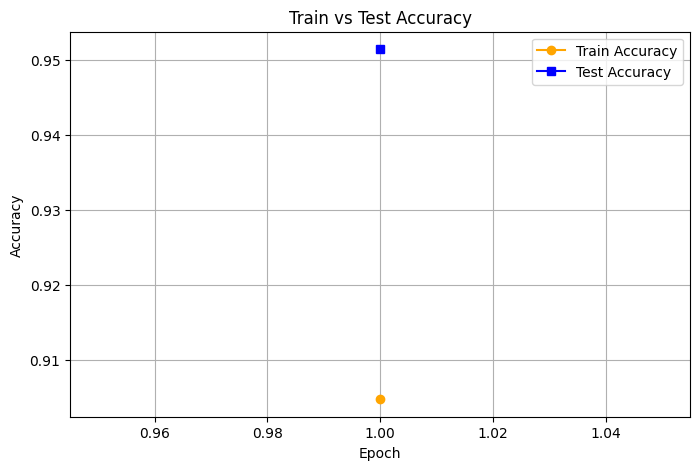

In [28]:
# Plot train vs validation accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o', color='orange')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy', marker='s', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
writer.add_figure("Accuracy/train_vs_test", fig)
plt.show()

In [ ]:
writer.add_graph(model, images)
writer.flush()

## Step 4: Evaluation

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

running_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

val_loss = running_loss / total
val_accuracy = correct / total

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Optional: detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Optional: confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

Validation Loss: 0.1649
Validation Accuracy: 0.9576

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       495
           1       0.97      0.99      0.98       563
           2       0.95      0.92      0.93       520
           3       0.92      0.96      0.94       503
           4       0.97      0.97      0.97       502
           5       0.93      0.93      0.93       445
           6       0.94      0.97      0.95       480
           7       0.96      0.95      0.96       500
           8       0.98      0.95      0.97       494
           9       0.97      0.94      0.96       498

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000


Confusion Matrix:
[[482   1   0   0   1   1   8   2   0   0]
 [  0 558   5   0   0   0   0   0   0   0]
 [  1   2 479  11   1  10   7   4   4   1]
 [  0   0   5 483

In [15]:
gc.collect()

5842

## Step 5: Save the model

In [21]:
# Save
torch.save(model.state_dict(), "simple_classifier.pth")

# Load
model = SimpleClassifier()           # create the model instance
model.load_state_dict(torch.load("simple_classifier.pth"))
model.eval()

SimpleClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
# Finally, flush and close the writer when done
writer.flush()
writer.close()

## Topic 2: Common Layer Types

### Type 1: Linear Layers
The most basic type of neural network layer is a linear or fully connected layer. This is a layer where every input influences every output of the layer to a degree specified by the layer’s weights. If a model has m inputs and n outputs, the weights will be an m x n matrix. For example:

In [16]:
Lin = nn.Linear(3,2)
x = torch.rand(4,3)
y = Lin(x)

print(f"Input: {x}")
print(x)
print(f"Shape: {x.shape}")

print('\n\nOutput:')
print(y)
print(f"Shape: {y.shape}")

Input: tensor([[0.4537, 0.7313, 0.0048],
        [0.4825, 0.7484, 0.2410],
        [0.5308, 0.6558, 0.4211],
        [0.4793, 0.2558, 0.3763]])
tensor([[0.4537, 0.7313, 0.0048],
        [0.4825, 0.7484, 0.2410],
        [0.5308, 0.6558, 0.4211],
        [0.4793, 0.2558, 0.3763]])
Shape: torch.Size([4, 3])


Output:
tensor([[-0.0873, -0.3719],
        [ 0.0418, -0.4292],
        [ 0.1324, -0.4666],
        [ 0.0413, -0.4226]], grad_fn=<AddmmBackward0>)
Shape: torch.Size([4, 2])


### Type 2: Convolutional Layers
Convolutional layers are built to handle data with a high degree of spatial correlation. They are very commonly used in computer vision, where they detect close groupings of features which the compose into higher-level features. They pop up in other contexts too - for example, in NLP applications, where a word’s immediate context (that is, the other words nearby in the sequence) can affect the meaning of a sentence.

In [17]:
conv1 = torch.nn.Conv2d(3, 5, 5)
x = torch.rand(3, 10, 10)
y = conv1(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")

Input shape: torch.Size([3, 10, 10])
Output shape: torch.Size([5, 6, 6])


### Type 3: Recurrent Layers
Recurrent neural networks (or RNNs) are used for sequential data - anything from time-series measurements from a scientific instrument to natural language sentences to DNA nucleotides. An RNN does this by maintaining a hidden state that acts as a sort of memory for what it has seen in the sequence so far.

In [18]:
# Define an RNN: input_size=4, hidden_size=3, num_layers=1
rnn = nn.RNN(input_size=4, hidden_size=3, num_layers=1, batch_first=True)

# Input: batch_size=2, sequence_length=5, input_size=4
x = torch.rand(2, 5, 4)  

# Pass through RNN
y, h = rnn(x)

print(f"Input shape: {x.shape}")     # (batch, seq_len, input_size)
print(f"Output shape: {y.shape}")    # (batch, seq_len, hidden_size)
print(f"Hidden state shape: {h.shape}")  # (num_layers, batch, hidden_size)


Input shape: torch.Size([2, 5, 4])
Output shape: torch.Size([2, 5, 3])
Hidden state shape: torch.Size([1, 2, 3])


### Type 4: Transformers
Transformers are multi-purpose networks that have taken over the state of the art in NLP with models like BERT. 

In [19]:
# Define a Transformer encoder layer
# d_model = 8 (embedding size), nhead = 2 (multi-head attention heads)
encoder_layer = nn.TransformerEncoderLayer(d_model=8, nhead=2, batch_first=True)

# Input: batch_size=2, sequence_length=5, embedding_dim=8
x = torch.rand(2, 5, 8)

# Pass through transformer encoder
y = encoder_layer(x)

print(f"Input shape: {x.shape}")   # (batch, seq_len, d_model)
print(f"Output shape: {y.shape}")  # (batch, seq_len, d_model)

Input shape: torch.Size([2, 5, 8])
Output shape: torch.Size([2, 5, 8])
